# GEM2 and Explorer from MCF2 catchment (Alento, Italy)

Data come from a national project focuses on small catchment (MCF2) in Italy. Alento (Campania) is located in the South of Italy ([Google Maps](https://www.google.com/maps/place/40%C2%B021'57.7%22N+15%C2%B011'01.5%22E/@40.366026,15.183741,10z/data=!4m5!3m4!1s0x0:0x0!8m2!3d40.366026!4d15.183741?hl=en)) and managed by "Nudsio Mano". The overall ground is very resistive because of fresh water. Bedrock is close to the surface (few meters). GEM2 data were collected in October 2020 with the instrument at 1 m above the ground. The GEM2 has a Tx-Rx distance of 1.66 m and was carried out in VDM (HCP) orientation. Around the same time, GF-Instrument multi-coil CMD-Explorer was used to record several transects accross the watershed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist
import pandas as pd
import sys
sys.path.append('../../../../software/emagpy/src')  # not needed if emagpy is installed
from emagpy import Problem

datadir = '../data/alento/'
outputdir = '../figures/'

letters = 'abcdefghijklmnopqrstuvwxyz'

In [2]:
def formatCoil(s):
    orientation = s[:3]
    coilspacing = s.split('f')[0][3:]
    freq = s.split('f')[1].split('h')[0]
    height = s.split('h')[1]
    return orientation + coilspacing + ' f' + freq + ' h' + height

## GEM 2 data analysis

In [3]:
# import measurement
kmf = Problem()
kmf.createSurvey(datadir + '2_GEM2 MFC2 29 OCT 2020.csv', unit='ppm')
kmf.rollingMean(window=5)

# shift all X and Y to a local coordinate system
x_shift = 515480
y_shift = 4468195
for survey in kmf.surveys:
    survey.df['x'] = survey.df['x'] - x_shift
    survey.df['y'] = survey.df['y'] - y_shift

Converting quadrature columns to LIN ECa. You can use "FSlin" or "Q" as forward model.
dataset shrunk of 4 measurements


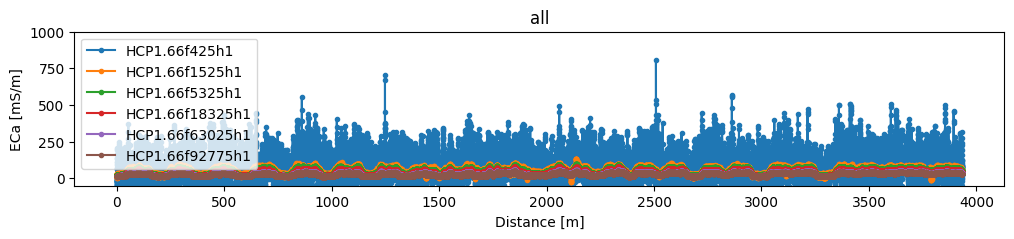

In [4]:
# quick overview
fig, ax = plt.subplots(figsize=(12,2))
kmf.show(vmin=-50, vmax=1000, ax=ax)

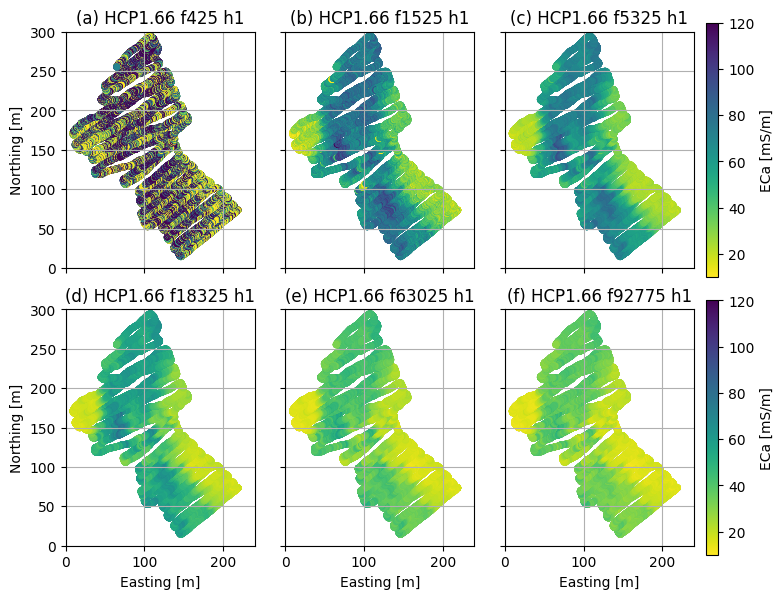

In [5]:
# maps
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 6))
axs = axs.flatten()
for i, coil in enumerate(kmf.coils):
    ax = axs[i]
    kmf.showMap(index=0, coil=coil, ax=ax, vmin=10, vmax=120)
    ax.set_aspect('equal')
    ax.grid()

    # cosmetic
    if i % 3 == 0:
        ax.set_ylabel('Northing [m]')
    else:
        ax.set_ylabel('')
    ax.set_title('({:s}) {:s}'.format(letters[i], formatCoil(coil[:3].upper() + coil[3:])))
    if i % 3 != 2:
        fig.axes[-1].remove()
    if i >= 3:
        ax.set_xlabel('Easting [m]')
    else:
        ax.set_xlabel('')
ax.set_xlim(0, 240)
ax.set_ylim(0, 300)
fig.tight_layout()
fig.savefig(outputdir + 'alento-mf-eca-map2020-10.jpg', dpi=500)

## GEM2 inversion
Operated on a decimated dataset

In [6]:
# import survey again for inversion (with some decimation)
k = Problem()
k.createSurvey(datadir + '2_GEM2 MFC2 29 OCT 2020.csv', unit='ppm')
k.rollingMean(window=5)

# shift all X and Y to a local coordinate system
x_shift = 515480
y_shift = 4468195
for survey in k.surveys:
    survey.df['x'] = survey.df['x'] - x_shift
    survey.df['y'] = survey.df['y'] - y_shift

# decimate a bit for faster inversion
for s in k.surveys:
    s.df = s.df[::50]
k.removeCoil(0) # remove noisy first frequency

Converting quadrature columns to LIN ECa. You can use "FSlin" or "Q" as forward model.
dataset shrunk of 4 measurements


In [7]:
depths = np.linspace(0.25, 3, 11)
k.setInit(depths0=depths)
k.invert(forwardModel='FSlin', method='Gauss-Newton')

648/648 inverted

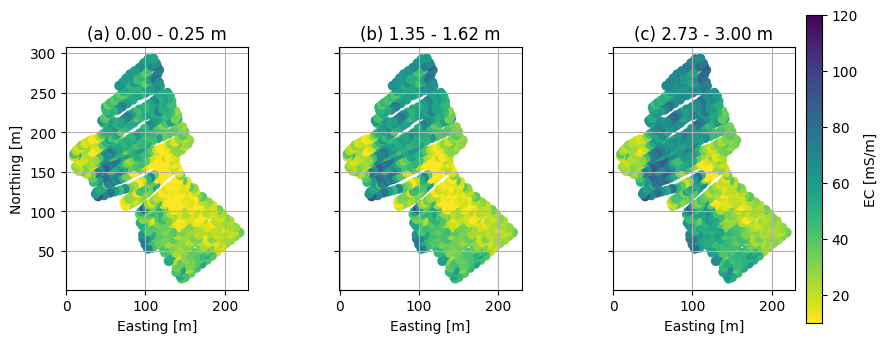

In [8]:
# figure of inverted survey selected
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4))
vmin = 10
vmax = 120
depths2 = np.r_[0, depths]

islices = [0, 5, 10]
for i, islice in enumerate(islices):
    ax = axs[i]
    ax.grid()
    k.showSlice(islice=i, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title('({:s}) {:.2f} - {:.2f} m'.format(letters[i], depths2[islice], depths2[islice+1]))
    if i < len(islices) -1:
        fig.axes[-1].remove()
    if i == 0:
        ax.set_ylabel('Northing [m]')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Easting [m]')
    ax.set_aspect('equal')
fig.savefig(outputdir + 'alento-mf-inv-selected.jpg', dpi=300)

## Explorer data analysis

In [9]:
# import data
kgf = Problem()
kgf.createSurvey(datadir + 'Alento-gf-utm33n.csv')

# shift all X and Y to a local coordinate system
x_shift = 515480
y_shift = 4468195
for survey in kgf.surveys:
    survey.df['x'] = survey.df['x'] - x_shift
    survey.df['y'] = survey.df['y'] - y_shift

Removing 1 NaN from survey


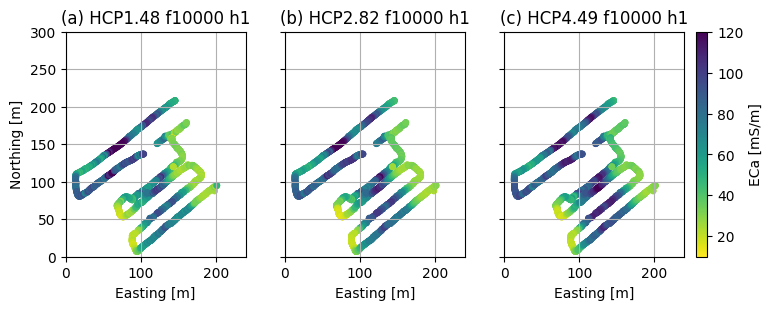

In [10]:
# figure selected date for gem2
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8, 3))
axs = axs.flatten()
for i, coil in enumerate(kgf.coils[:3]):
    ax = axs[i]
    ax.grid()
    kgf.showMap(index=0, coil=coil, ax=ax, vmin=10, vmax=120)
    ax.set_aspect('equal')

    # cosmetic
    if i % 3 == 0:
        ax.set_ylabel('Northing [m]')
    else:
        ax.set_ylabel('')
    ax.set_title('({:s}) {:s}'.format(letters[i], formatCoil(coil)))
    if i % 3 != 2:
        fig.axes[-1].remove()
    ax.set_xlabel('Easting [m]')
ax.set_xlim(0, 240)
ax.set_ylim(0, 300)
fig.tight_layout()
fig.subplots_adjust(bottom=0.15, top=0.9)
fig.savefig(outputdir + 'alento-gf-eca.jpg', dpi=500)

## Find common points

In [11]:
# select subset of common points between the two instruments
dfmf = kmf.surveys[0].df[['x', 'y'] + kmf.coils].copy()[::20]
dfmc = kgf.surveys[0].df.copy()[::1]
dist = cdist(dfmf[['x','y']].values, dfmc[['x','y']].values) # can run out of memory
imin = np.argmin(dist, axis=0)
print(dist.shape, imin.shape)
ie = dist[imin,np.arange(dist.shape[1])] < 2 # select all measurements where distance is below 1 m
print('Number of co-located points:', np.sum(ie))
#dfmc[ie].to_csv(datadir + 'dfmc.csv', index=False)
val = dfmf.values
dfmf2 = pd.DataFrame(val[imin[ie],:], columns=dfmf.columns.values)
#dfmf2.to_csv(datadir + 'dfmf.csv', index=False)

(1620, 1946) (1946,)
Number of co-located points: 677


In [12]:
# remove VCP coils to make a fairer comparison with GEM2
df = pd.read_csv(datadir + 'dfmc.csv')
df = df[df.columns[~df.columns.str.contains('VCP')]]
df.to_csv(datadir + 'dfmc2.csv')

## Comparison GEM2-Explorer

In [13]:
# import both common points surveys
kmc = Problem()
kmc.createSurvey(datadir + 'dfmc2.csv')
kmc.gfCorrection(calib='F-1m') # important!
kmf = Problem()
kmf.createSurvey(datadir + 'dfmf.csv')

Removing 1 NaN from survey
gfCorrection: F-1m calibrated ECa converted to LIN ECa


In [14]:
# inversion with identical settings
kmc.setInit(depths0=np.linspace(0.3, 3, 5))
kmc.invert(forwardModel='FSlin', method='Gauss-Newton')
kmf.setInit(depths0=np.linspace(0.3, 3, 5))
kmf.invert(forwardModel='FSlin', method='Gauss-Newton')

677/677 inverted

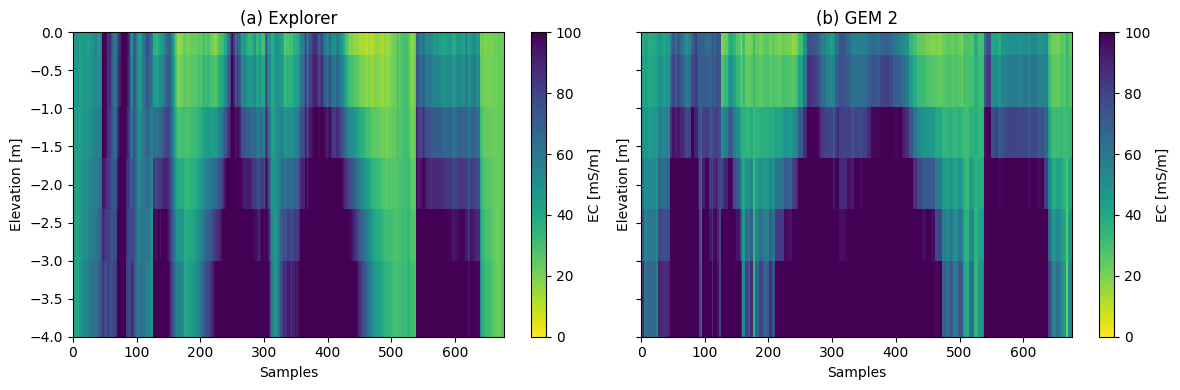

In [15]:
# viewing all locations in common
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
ax = axs[0]
kmc.showResults(ax=ax, dist=False, vmin=0, vmax=100)
ax.set_title('(a) Explorer')
ax = axs[1]
kmf.showResults(ax=ax, dist=False, vmin=0, vmax=100)
ax.set_title('(b) GEM 2')
fig.savefig(outputdir + 'alento-mf-mc-inv.jpg', dpi=500)

Text(0.5, 1.0, '(b) GEM 2')

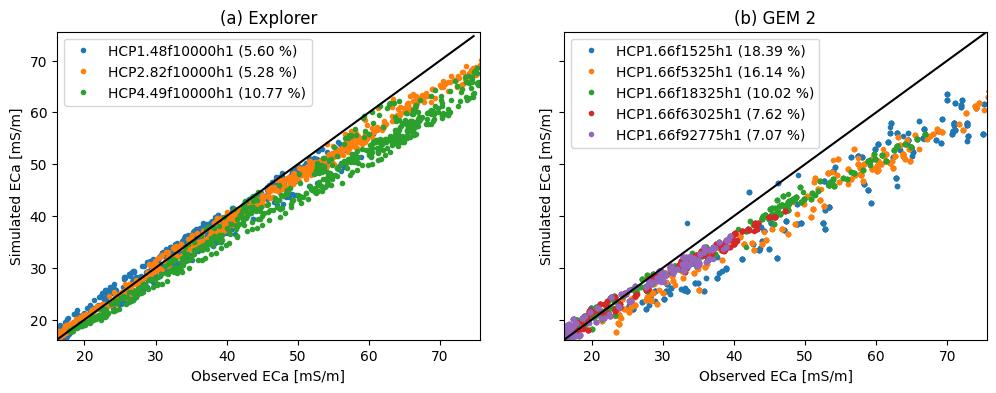

In [16]:
# quality of fit
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
ax = axs[0]
kmc.showOne2one(coil=kmc.coils, ax=ax)
ax.set_title('(a) Explorer')
ax = axs[1]
kmf.showOne2one(ax=ax)
ax.set_title('(b) GEM 2')

depth 0.45m: mf = 0.56*mc + 18.93 (r=0.68)
depth 1.31m: mf = 0.65*mc + 18.47 (r=0.74)
depth 1.99m: mf = 0.84*mc + 16.15 (r=0.84)
depth 2.66m: mf = 1.01*mc + 14.37 (r=0.90)
depth 3.34m: mf = 1.14*mc + 15.23 (r=0.92)
R2= 0.7830466946484721


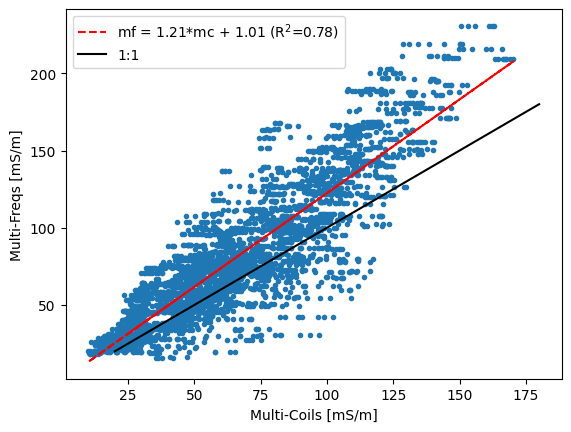

In [17]:
# one one line
ecmc, ecmf = kmc.models[0], kmf.models[0]
cdepths = kmc.depths[0][0,:] + np.diff(np.r_[0, kmc.depths[0][0,:]])/2
fig, ax = plt.subplots()
for i in range(ecmc.shape[1]-1): # we don't compare the last layer
    x, y = ecmc[:,i], ecmf[:,i]
    res = stats.linregress(x,y)
    print('depth {:.2f}m: mf = {:.2f}*mc + {:.2f} (r={:.2f})'.format(
        cdepths[i], res.slope, res.intercept, res.rvalue))
x, y = ecmc.flatten(), ecmf.flatten()
res = stats.linregress(x,y)
ypred = res.intercept + res.slope * x
r2 = 1 - np.sum((y - ypred)**2)/np.sum((y - np.mean(y))**2)
print('R2=', r2)
ax.plot(x, y, '.')
ax.plot(x, ypred, 'r--', label='mf = {:.2f}*mc + {:.2f} (R$^2$={:.2f})'.format(
    res.slope, res.intercept, res.rvalue**2))
ax.plot([20,180],[20,180], 'k-', label='1:1')
ax.legend()
ax.set_xlabel('Multi-Coils [mS/m]')
ax.set_ylabel('Multi-Freqs [mS/m]')
fig.savefig(outputdir + 'alento-mf-mc-one2one.jpg', dpi=500)

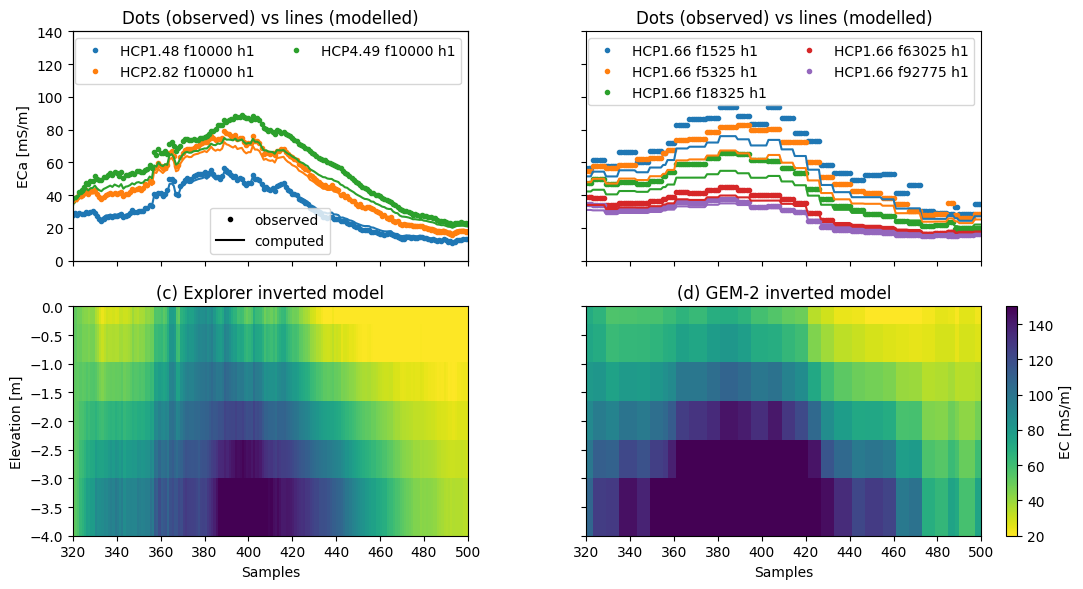

In [20]:
# comparing ECa, fit and inverted EC
start = 320
end = 500
fig, axs = plt.subplots(2, 2, figsize=(11, 6), sharey='row', sharex=True)
ax = axs[0, 0]
ax.set_title('(a) Explorer ECa')
kmc.showMisfit(ax=ax)
[ax.get_lines()[i].set_label(formatCoil(coil)) for i, coil in enumerate(kmc.coils)]
ax.set_xlabel('')
ax.legend(ncol=2)
ax.set_xlim([start, end])
ax2 = ax.twinx()
ax2.plot([], [], 'k.', label='observed')
ax2.plot([], [], 'k-', label='computed')
ax2.legend(loc='lower center', fontsize=10)
ax2.set_yticks([])

ax = axs[0, 1]
ax.set_title('(b) GEM-2 ECa')
kmf.showMisfit(ax=ax)
[ax.get_lines()[i].set_label(formatCoil(coil)) for i, coil in enumerate(kmf.coils)]
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend(ncol=2, fontsize=10)
ax.set_xlim([start, end])
ax.set_ylim([0, 140])

ax = axs[1, 0]
kmc.showResults(ax=ax, dist=False, vmin=20, vmax=150)
ax.set_title('(c) Explorer inverted model')
ax.set_xlim([start, end])
fig.axes[-1].remove()

ax = axs[1, 1]
kmf.showResults(ax=ax, dist=False, vmin=20, vmax=150)
ax.set_title('(d) GEM-2 inverted model')
ax.set_ylabel('')
ax.set_xlim([start, end])
fig.tight_layout()

# realign the first axis
pos = axs[1, 0].get_position().bounds
pos0 = axs[0, 0].get_position().bounds
pos0 = (pos[0], pos0[1], pos[2], pos0[3])
axs[0, 0].set_position(pos0)

pos = axs[1, 1].get_position().bounds
pos0 = axs[0, 1].get_position().bounds
pos0 = (pos[0], pos0[1], pos[2], pos0[3])
axs[0, 1].set_position(pos0)

fig.savefig(outputdir + 'alento-mf-mc-eca.jpg', dpi=300)